# Checks of TF PV Correlations

Check correlations between PV parameters to ensure dust and k-corrections are properly zeroing out any redshift-dependent biases.

This is a companion to the notebook `TF_iron_internal-dustCorr.ipynb`.

In [1]:
import os

from astropy.table import Table
from astropy.coordinates import Distance
from astropy.cosmology import Planck18
import astropy.units as u

import numpy as np

from scipy.stats import binned_statistic

import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt

# Custom functions / classes
import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
# sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust

In [2]:
mpl.rc('font', size=14)

## Profile Histogram Code

Here we use "profile histogram" in the sense of the ROOT CERN package. This just produces data suitable for plotting in an errorbar plot showing binned statistics (mean, weighted mean, or median) as a function of some independent variable.

In [3]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

def linear_fit(x, y, yerr=None, weights=None):
    """Perform a linear least squares fit to data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        Weights to use in the fit.  Default is None (use either yerr or do not 
        weight).
        
    Returns
    -------
    a : float
        Intercept.
    b : float
        Slope.
    """

    if weights is None:
        weights = np.ones_like(y) if yerr is None else 1./yerr**2

    #- Filter out an NaN values
    if np.any(np.isnan(x)) or np.any(np.isnan(y)) or np.any(np.isnan(weights)):
        good = np.isfinite(x) & np.isfinite(y) & np.isfinite(weights)
    else:
        good = np.ones(len(x), dtype=bool)

    #- Create design matrix
    X = np.vstack([np.ones(len(x[good])), x[good]]).T

    #- Calculate weighted least squares
    W = np.diag(weights[good])
    coeffs, _, _, _ = np.linalg.lstsq(np.dot(W, X), np.dot(W, y[good]), rcond=None)
        
    return coeffs

## Read Previous and Current Versions of the TF Catalog

Read in the catalog and store some derived data into new tables.

In [3]:
pvpath = os.path.join(os.environ['CFS'], 'desi/science/td/pv/tfgalaxies/Y1')

pvfile1 = os.path.join(pvpath, 'DESI-DR1_TF_pv_cat_v1.fits')
pvdata1 = Table.read(pvfile1)

pvfile3 = os.path.join(pvpath, 'DESI-DR1_TF_pv_cat_v3.fits')
pvdata3 = Table.read(pvfile3)

pvfile4 = os.path.join(pvpath, 'DESI-DR1_TF_pv_cat_v4.fits')
pvdata4 = Table.read(pvfile4)

pvfile5 = 'SGA_iron_jointTFR-varyV0-perpdwarf-fitH0_zCMB0p1_moduli_pec-Watkins15.fits'
pvdata5 = Table.read(pvfile5)

pvdata5

<Table length=10263>
 SGA_ID    SGA_GALAXY    ...        V_PEC             VERR_PEC     
 int64      bytes16      ...       float64            float64      
------- ---------------- ... ------------------- ------------------
     38      SGA-2020 38 ...  3434.8403471121396 1412.9422666181747
     55      SGA-2020 55 ...   369.9708069962825  899.1937516075815
    117     SGA-2020 117 ...   3336.978783459342  2161.127722739238
    223     SGA-2020 223 ...  21.888070807398943  942.0638845270777
    581     SGA-2020 581 ...  1148.3159084409237  1047.331216578973
    669     SGA-2020 669 ...  -8376.196731505404   922.987298576926
    731     SGA-2020 731 ...  13628.547913148921  1781.455875239221
   1135    SGA-2020 1135 ... -1623.3820131204145 1064.4248826821438
   1158    SGA-2020 1158 ...  -119.8192371234864  766.9327790172246
   1287    SGA-2020 1287 ...  -2405.103008258844  1056.917352262065
    ...              ... ...                 ...                ...
5002603 SGA-2020 5002603 ... -2373.4536312050272 2756.7254923054134
5002677 SGA-2020 5002677 ...  3657.3569489909237 3709.1169589184155
5002752 SGA-2020 5002752 ...   442.1372926480425 1286.4390217730938
5002778 SGA-2020 5002778 ...  -7507.791449117904 2183.2380063428645
5002994 SGA-2020 5002994 ...  1142.9262793422129 1532.3707417173152
5003016 SGA-2020 5003016 ...  29902.353498251257 1580.4122992751675
5003025 SGA-2020 5003025 ...  12929.035014837964 1721.3483497775571
5003042 SGA-2020 5003042 ...   3831.713234795795   5680.66594840475
5003044 SGA-2020 5003044 ...  -2130.784515678287   5247.75227875684
5003075 SGA-2020 5003075 ...   6858.977755094082 1937.3737659062797

In [4]:
tab1, tab4, tab5 = Table(), Table(), Table()

#- Collect data from v1, v4, and v5 of the catalogs
for _t, _p in zip([tab1, tab4, tab5], [pvdata1, pvdata4, pvdata5]):
# for _t, _p in zip([tab5], [pvdata5]):
    isdwarf = _p['R_ABSMAG_SB26_TF'] > -17
    
    #- Rotational velocities
    _t['V_0p4R26']     = _p['V_0p4R26'][~isdwarf]
    if 'V_0p4R26_err' in _p.colnames:
        _t['V_0p4R26_err'] = _p['V_0p4R26_err'][~isdwarf]
    else:
        _t['V_0p4R26_err'] = _p['V_0p4R26_ERR'][~isdwarf]
    
    _t['logV_0p4R26'] = np.log10(_t['V_0p4R26'])
    _t['logV_0p4R26_err'] = 0.434 * _t['V_0p4R26_err'] / _t['V_0p4R26']
    
    #- R magnitude (apparent and absolute)
    _t['R_ABSMAG_SB26'] = _p['R_ABSMAG_SB26'][~isdwarf]
    _t['R_MAG_SB26'] = _p['R_MAG_SB26'][~isdwarf]
    _t['R_MAG_SB26_ERR'] = _p['R_MAG_SB26_ERR'][~isdwarf]
    _t['R_MAG_SB26_CORR'] = _p['R_MAG_SB26_CORR'][~isdwarf]
    if 'R_ABSMAG_SB26_ERR' in _p.colnames:
        _t['R_ABSMAG_SB26_ERR'] = _p['R_ABSMAG_SB26_ERR'][~isdwarf]
    else:
        _t['R_ABSMAG_SB26_ERR'] = _p['R_ABSMAG_SB26_err'][~isdwarf]
    if 'R_MAG_SB26_ERR_CORR' in _p.colnames:
        _t['R_MAG_SB26_CORR_ERR'] = _p['R_MAG_SB26_ERR_CORR'][~isdwarf]
    else:
        _t['R_MAG_SB26_CORR_ERR'] = _p['R_MAG_SB26_err_corr'][~isdwarf]
    
    #- TF distance modulus and uncertainty
    if 'MU_TF' in _p.colnames:
        _t['MU_TF'] = _p['MU_TF'][~isdwarf]
        _t['MU_TF_ERR'] = _p['MU_TF_ERR'][~isdwarf]
    else:
        _t['MU_TF'] = _p['mu_TF'][~isdwarf]
        _t['MU_TF_ERR'] = _p['mu_TF_err'][~isdwarf]
    
    #- Redshift and peculiar velocities
    if 'Z_DESI_CMB' in _p.colnames:
        _t['Z_DESI'] = _p['Z_DESI_CMB'][~isdwarf]
    else:
        _t['Z_DESI'] = _p['Z_DESI'][~isdwarf]
    _t['V_PEC'] = _p['V_PEC'][~isdwarf]
    _t['VERR_PEC'] = _p['VERR_PEC'][~isdwarf]
    if 'logdist' in _p.colnames:
        _t['LOGDIST'] = _p['logdist'][~isdwarf]
        _t['LOGDIST_ERR'] = _p['logdist_err'][~isdwarf]
    elif 'LOGDIST' in _p.colnames:
        _t['LOGDIST'] = _p['LOGDIST'][~isdwarf]
        _t['LOGDIST_ERR'] = _p['LOGDIST_ERR'][~isdwarf]

    #- Galaxy geometry
    _t['BA'] = _p['BA'][~isdwarf]
    _t['D26'] = _p['D26'][~isdwarf]
    # Convert D26 to kpc
    dist = Distance(z=np.abs(_t['Z_DESI']), cosmology=Planck18)
    _t['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*_t['D26']*u.arcmin)
    _t['dist_max'] = 0.5*_t['D26_kpc']/np.tan(0.1*u.arcmin)
    
    #- Galaxy colors
    if 'G_MAG_SB26_CORR' in _p.colnames:
        _t['g-r'] = _p['G_MAG_SB26_CORR'][~isdwarf] - _t['R_MAG_SB26_CORR']
        _t['r-z'] = _t['R_MAG_SB26_CORR'] - _p['Z_MAG_SB26_CORR'][~isdwarf]
    else:
        _t['g-r'] = _p['G_MAG_SB26'][~isdwarf] - _p['R_MAG_SB26'][~isdwarf]
        _t['r-z'] = _p['R_MAG_SB26'][~isdwarf] - _p['Z_MAG_SB26'][~isdwarf]

In [5]:
# Also read in the full SGA catalog
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

## Plot All the Things!

### Peculiar velocity vs redshift

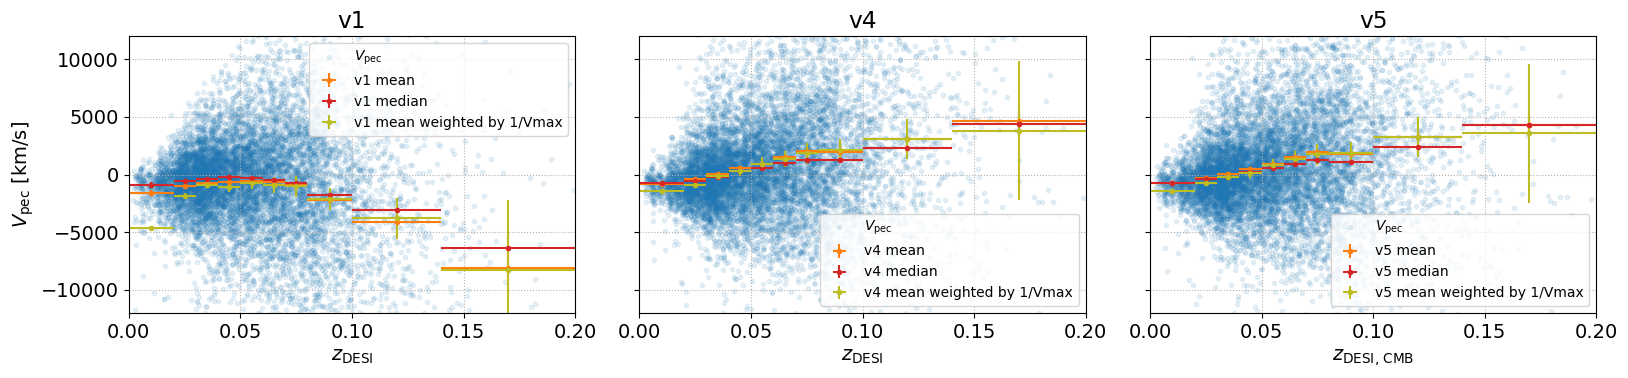

In [19]:
zbins = np.asarray([0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.14, 0.2])
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1['Z_DESI'], tab1['V_PEC'], marker='.', alpha=0.1, label='$V_\mathrm{pec}$')

#- Plot the mean and median
N, vpec_avg, vpec_std = profile_histogram(tab1['Z_DESI'], tab1['V_PEC'], zbins, tab1['VERR_PEC'])
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='v1 mean', color='tab:orange')
N, vpec_avg, vpec_std = profile_histogram(tab1['Z_DESI'], tab1['V_PEC'], zbins, tab1['VERR_PEC'], median=True)
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='v1 median', color='tab:red')
N, vpec_avg, vpec_std = profile_histogram(tab1['Z_DESI'], tab1['V_PEC'], zbins, weights=1/tab1['dist_max'].to('Mpc')**3, weighted=True)
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='v1 mean weighted by 1/Vmax', color='tab:olive')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v1',
       xlim=[0, 0.2],
       ylim=[-12000, 12000],
       xlabel=r'$z_\text{DESI}$',
       ylabel=r'$V_\text{pec}$ [km/s]')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4['Z_DESI'], tab4['V_PEC'], marker='.', alpha=0.1, label='$V_\mathrm{pec}$')

#- Plot the mean and median
N, vpec_avg, vpec_std = profile_histogram(tab4['Z_DESI'], tab4['V_PEC'], zbins, tab4['VERR_PEC'])
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='v4 mean', color='tab:orange')
N, vpec_avg, vpec_std = profile_histogram(tab4['Z_DESI'], tab4['V_PEC'], zbins, tab4['VERR_PEC'], median=True)
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='v4 median', color='tab:red')
N, vpec_avg, vpec_std = profile_histogram(tab4['Z_DESI'], tab4['V_PEC'], zbins, weights=1/tab4['dist_max'].to('Mpc')**3, weighted=True)
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='v4 mean weighted by 1/Vmax', color='tab:olive')

ax.legend(loc='lower right', fontsize=10)
ax.set(title='v4',
       xlabel=r'$z_\text{DESI}$')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5['Z_DESI'], tab5['V_PEC'], marker='.', alpha=0.1, label='$V_\mathrm{pec}$')

#- Plot the mean and median
N, vpec_avg, vpec_std = profile_histogram(tab5['Z_DESI'], tab5['V_PEC'], zbins, tab5['VERR_PEC'])
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='v5 mean', color='tab:orange')
N, vpec_avg, vpec_std = profile_histogram(tab5['Z_DESI'], tab5['V_PEC'], zbins, tab5['VERR_PEC'], median=True)
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='v5 median', color='tab:red')
N, vpec_avg, vpec_std = profile_histogram(tab5['Z_DESI'], tab5['V_PEC'], zbins, weights=1/tab5['dist_max'].to('Mpc')**3, weighted=True)
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='v5 mean weighted by 1/Vmax', color='tab:olive')

ax.legend(loc='lower right', fontsize=10)
ax.set(title='v5',
       xlabel=r'$z_\text{DESI, CMB}$')
ax.grid(ls=':');

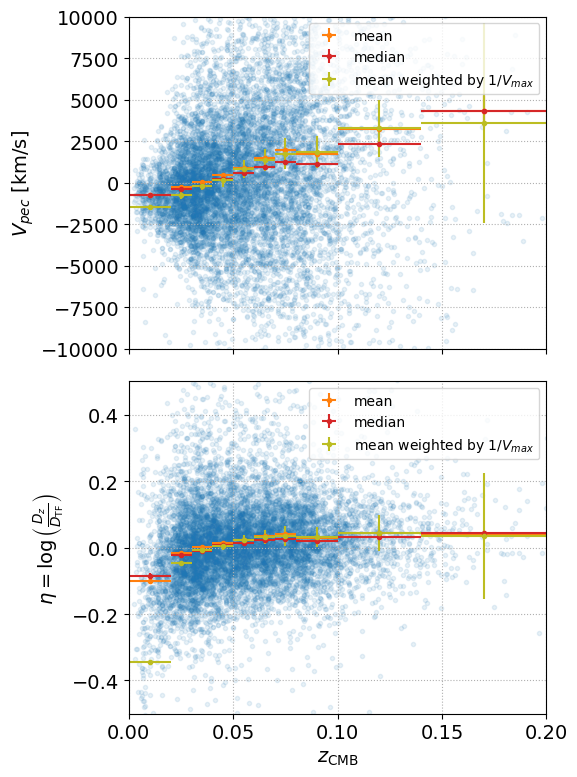

In [24]:
zbins = np.asarray([0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.14, 0.2])
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

fig, axes = plt.subplots(2,1, figsize=(6,8), sharex=True, sharey=False, tight_layout=True)


ax = axes[0]
ax.scatter(tab5['Z_DESI'], tab5['V_PEC'], marker='.', alpha=0.1)#, label='$V_\mathrm{pec}$')

#- Plot the mean and median
N, vpec_avg, vpec_std = profile_histogram(tab5['Z_DESI'], tab5['V_PEC'], zbins, tab5['VERR_PEC'])
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='mean', color='tab:orange')
N, vpec_med, vpec_std = profile_histogram(tab5['Z_DESI'], tab5['V_PEC'], zbins, tab5['VERR_PEC'], median=True)
ax.errorbar(zc, vpec_med, xerr=dz, yerr=vpec_std, fmt='.', label='median', color='tab:red')
N, vpec_avg, vpec_std = profile_histogram(tab5['Z_DESI'], tab5['V_PEC'], zbins, weights=1/tab5['dist_max'].to('Mpc')**3, weighted=True)
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='mean weighted by 1/$V_{max}$', color='tab:olive')

ax.legend(loc='upper right', fontsize=10)
ax.set(#xlabel=r'$z_\text{CMB}$', 
       ylabel='$V_{pec}$ [km/s]', 
       xlim=[0, 0.2], 
       ylim=[-10000, 10000])
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab5['Z_DESI'], tab5['LOGDIST'], marker='.', alpha=0.1)#, label='$V_\mathrm{pec}$')

#- Plot the mean and median
N, logdist_avg, logdist_std = profile_histogram(tab5['Z_DESI'], tab5['LOGDIST'], zbins, tab5['LOGDIST_ERR'])
ax.errorbar(zc, logdist_avg, xerr=dz, yerr=logdist_std, fmt='.', label='mean', color='tab:orange')
N, logdist_med, logdist_std = profile_histogram(tab5['Z_DESI'], tab5['LOGDIST'], zbins, tab5['LOGDIST_ERR'], median=True)
ax.errorbar(zc, logdist_med, xerr=dz, yerr=logdist_std, fmt='.', label='median', color='tab:red')
N, logdist_med, logdist_std = profile_histogram(tab5['Z_DESI'], tab5['LOGDIST'], zbins, weights=1/tab5['dist_max'].to('Gpc')**3, weighted=True)
ax.errorbar(zc, logdist_med, xerr=dz, yerr=logdist_std, fmt='.', label='mean weighted by 1/$V_{max}$', color='tab:olive')

ax.legend(loc='upper right', fontsize=10)
ax.set(xlabel=r'$z_\text{CMB}$', 
       ylabel=r'$\eta = \log \left( \frac{D_z}{D_\text{TF}} \right)$', 
       ylim=[-0.5, 0.5])
ax.grid(ls=':');

# plt.savefig('../../Figures/Y1/iron_PV_z_v3.png', dpi=150, facecolor='none');

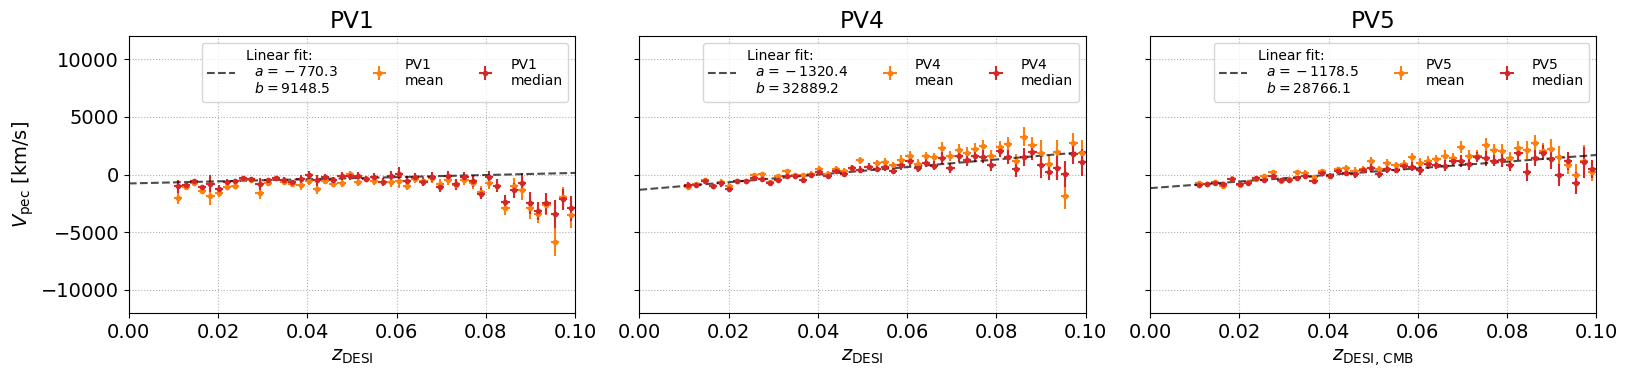

In [18]:
zbins = np.linspace(0.01, 0.1, 50)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)


ax = axes[0]

#- Plot the mean and median
N, vpec_avg, vpec_std = profile_histogram(tab1['Z_DESI'], tab1['V_PEC'], zbins, tab1['VERR_PEC'])
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='PV1\nmean', color='tab:orange')
N, vpec_avg, vpec_std = profile_histogram(tab1['Z_DESI'], tab1['V_PEC'], zbins, tab1['VERR_PEC'], median=True)
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='PV1\nmedian', color='tab:red')

#- Perform a fit to the median
a, b = linear_fit(zc, vpec_avg, vpec_std)
_z = np.arange(0, 0.11, 0.01)
ax.plot(_z, a + b*_z, ls='--', color='k', alpha=0.7, label=f'Linear fit:\n  $a={a:.1f}$\n  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10, ncol=3)
ax.set(title='PV1',
       xlim=[0, 0.1],
       ylim=[-12000, 12000],
       xlabel=r'$z_\text{DESI}$',
       ylabel=r'$V_\text{pec}$ [km/s]')
ax.grid(ls=':')


ax = axes[1]

#- Plot the mean and median
N, vpec_avg, vpec_std = profile_histogram(tab4['Z_DESI'], tab4['V_PEC'], zbins, tab4['VERR_PEC'])
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='PV4\nmean', color='tab:orange')
N, vpec_avg, vpec_std = profile_histogram(tab4['Z_DESI'], tab4['V_PEC'], zbins, tab4['VERR_PEC'], median=True)
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='PV4\nmedian', color='tab:red')

#- Perform a fit to the median
a, b = linear_fit(zc, vpec_avg, vpec_std)
_z = np.arange(0, 0.11, 0.01)
ax.plot(_z, a + b*_z, ls='--', color='k', alpha=0.7, label=f'Linear fit:\n  $a={a:.1f}$\n  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10, ncol=3)
ax.set(title='PV4',
       xlabel=r'$z_\text{DESI}$')
ax.grid(ls=':')


ax = axes[2]

#- Plot the mean and median
N, vpec_avg, vpec_std = profile_histogram(tab5['Z_DESI'], tab5['V_PEC'], zbins, tab5['VERR_PEC'])
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='PV5\nmean', color='tab:orange')
N, vpec_avg, vpec_std = profile_histogram(tab5['Z_DESI'], tab5['V_PEC'], zbins, tab5['VERR_PEC'], median=True)
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='PV5\nmedian', color='tab:red')

#- Perform a fit to the median
a, b = linear_fit(zc, vpec_avg, vpec_std)
_z = np.arange(0, 0.11, 0.01)
ax.plot(_z, a + b*_z, ls='--', color='k', alpha=0.7, label=f'Linear fit:\n  $a={a:.1f}$\n  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10, ncol=3)
ax.set(title='PV5',
       xlabel=r'$z_\text{DESI, CMB}$')
ax.grid(ls=':');

### r-band magnitude vs axis ratio

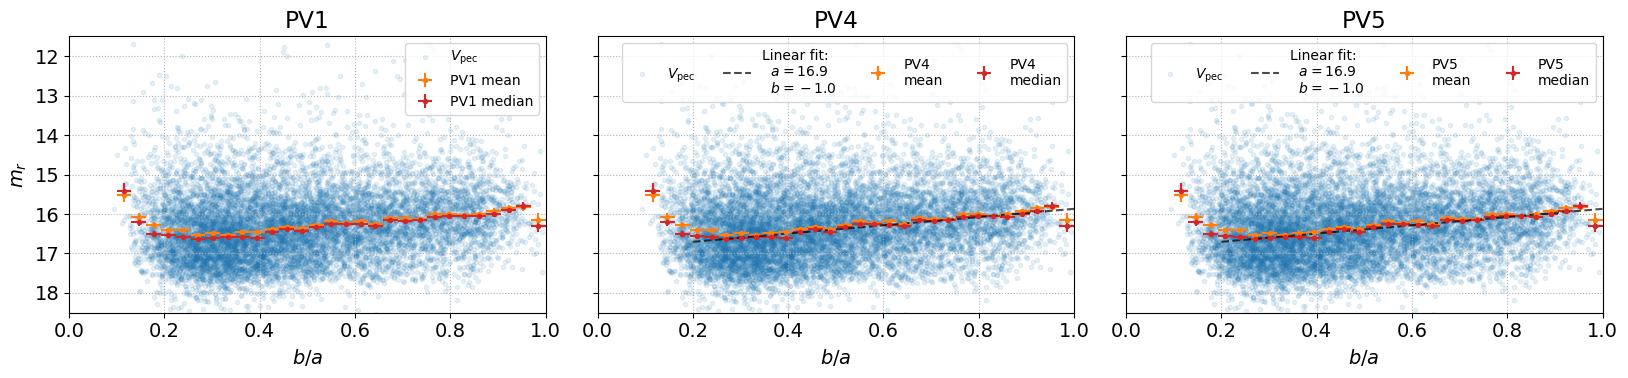

In [20]:
xbins = np.linspace(0.1, 1, 30)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)


ax = axes[0]
ax.scatter(tab1['BA'], tab1['R_MAG_SB26'], marker='.', alpha=0.1, label='$V_\mathrm{pec}$')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1['BA'], tab1['R_MAG_SB26'], xbins, tab1['R_MAG_SB26_ERR'])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1['BA'], tab1['R_MAG_SB26'], xbins, tab1['R_MAG_SB26_ERR'], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV1',
       xlim=[0, 1],
       ylim=[18.5, 11.5],
       xlabel=r'$b/a$',
       ylabel=r'$m_r$')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4['BA'], tab4['R_MAG_SB26'], marker='.', alpha=0.1, label='$V_\mathrm{pec}$')

#- Plot the mean and median
N, y_avg, y_std = profile_histogram(tab4['BA'], tab4['R_MAG_SB26'], xbins, tab4['R_MAG_SB26_ERR'])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV4\nmean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab4['BA'], tab4['R_MAG_SB26'], xbins, tab4['R_MAG_SB26_ERR'], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV4\nmedian', color='tab:red')

#- Perform a fit to the median
select = (xc >= 0.2) & (xc <= 0.95)
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
_x = np.arange(0.2, 1.05, 0.05)
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:\n  $a={a:.1f}$\n  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10, ncol=4)
ax.set(title='PV4',
       xlabel=r'$b/a$')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5['BA'], tab5['R_MAG_SB26'], marker='.', alpha=0.1, label='$V_\mathrm{pec}$')

#- Plot the mean and median
N, y_avg, y_std = profile_histogram(tab5['BA'], tab5['R_MAG_SB26'], xbins, tab5['R_MAG_SB26_ERR'])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV5\nmean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab5['BA'], tab5['R_MAG_SB26'], xbins, tab5['R_MAG_SB26_ERR'], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV5\nmedian', color='tab:red')

#- Perform a fit to the median
select = (xc >= 0.2) & (xc <= 0.95)
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
_x = np.arange(0.2, 1.05, 0.05)
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:\n  $a={a:.1f}$\n  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10, ncol=4)
ax.set(title='PV5',
       xlabel=r'$b/a$')
ax.grid(ls=':');

Note that these should all be the same, since there is no difference in either $m_r$ or $b/a$ between the different catalog versions.

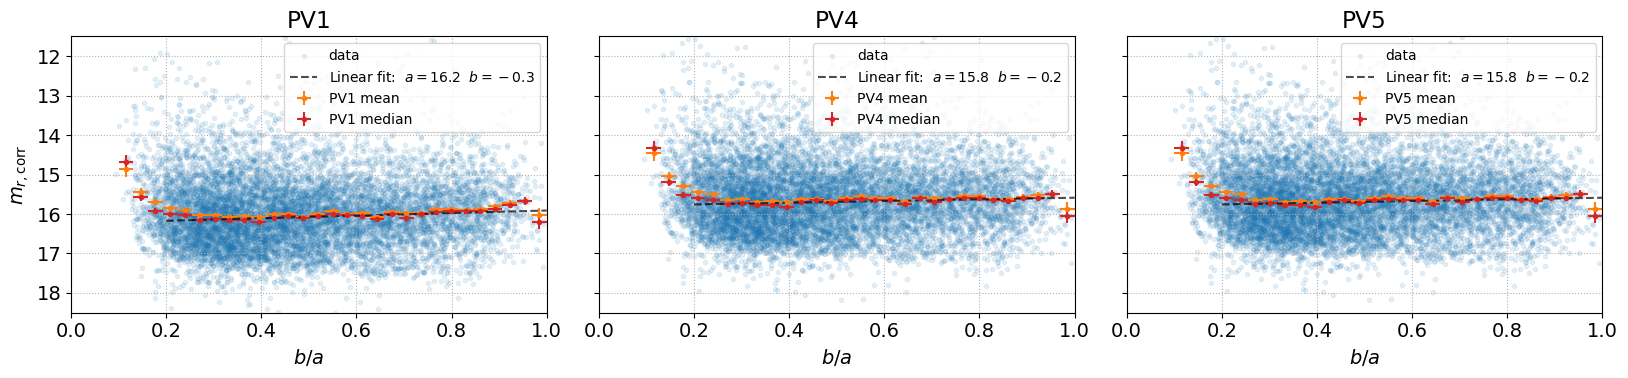

In [26]:
xbins = np.linspace(0.1, 1, 30)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'BA'
yval = 'R_MAG_SB26_CORR'
yval_err = 'R_MAG_SB26_CORR_ERR'

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:red')

#- Perform a fit to the median
select = (xc >= 0.2) & (xc <= 0.95)
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
_x = np.arange(0.2, 1.05, 0.05)
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:  $a={a:.1f}$  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV1',
       xlim=[0, 1],
       ylim=[18.5, 11.5],
       xlabel=r'$b/a$',
       ylabel=r'$m_{r,\text{corr}}$')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4[xval], tab4[yval], marker='.', alpha=0.1, label='data')

#- Plot PV1 on top...
# ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1', color='tab:red')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV4 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV4 median', color='tab:red')

#- Perform a fit to the median
select = (xc >= 0.2) & (xc <= 0.95)
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
_x = np.arange(0.2, 1.05, 0.05)
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:  $a={a:.1f}$  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV4',
       xlabel=r'$b/a$')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5[xval], tab5[yval], marker='.', alpha=0.1, label='data')

#- Plot PV1 on top...
# ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1', color='tab:red')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV5 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV5 median', color='tab:red')

#- Perform a fit to the median
select = (xc >= 0.2) & (xc <= 0.95)
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
_x = np.arange(0.2, 1.05, 0.05)
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:  $a={a:.1f}$  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV5',
       xlabel=r'$b/a$')
ax.grid(ls=':');

There's still a slight correlation between the corrected $m_r$ and the axis ratio...

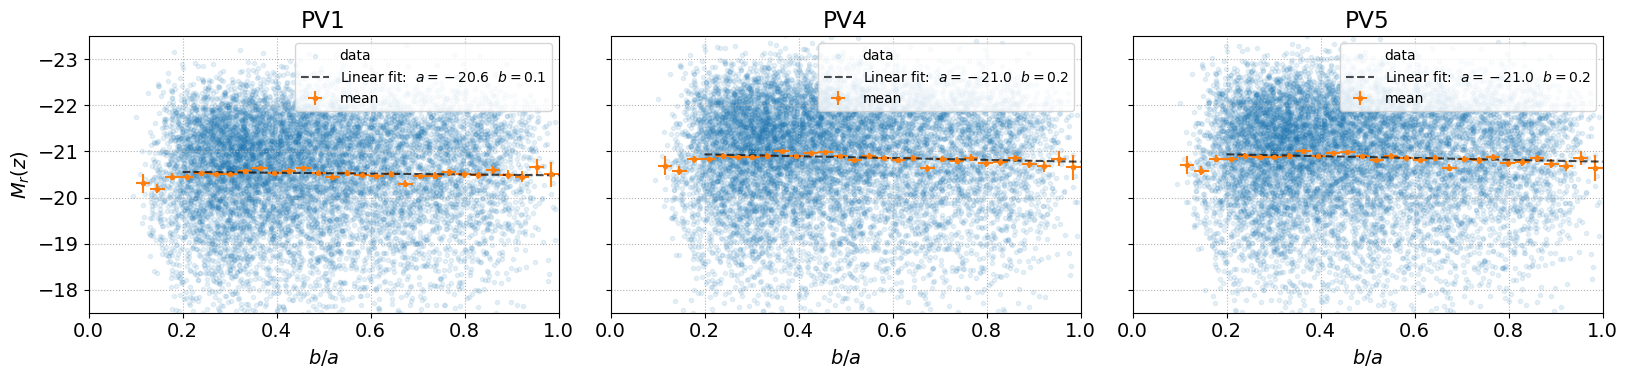

In [27]:
xbins = np.linspace(0.1, 1, 30)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'BA'
yval = 'R_ABSMAG_SB26'
yval_err = 'R_ABSMAG_SB26_ERR'

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='mean', color='tab:orange')

#- Perform a fit to the mean
select = (xc >= 0.2) & (xc <= 0.95)
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
_x = np.arange(0.2, 1.05, 0.05)
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:  $a={a:.1f}$  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV1',
       xlim=[0, 1],
       ylim=[-17.5, -23.5],
       xlabel=r'$b/a$',
       ylabel=r'$M_r(z)$')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4[xval], tab4[yval], marker='.', alpha=0.1, label='data')
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='mean', color='tab:orange')

#- Perform a fit to the mean
select = (xc >= 0.2) & (xc <= 0.95)
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
_x = np.arange(0.2, 1.05, 0.05)
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:  $a={a:.1f}$  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV4',
       xlabel=r'$b/a$')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5[xval], tab5[yval], marker='.', alpha=0.1, label='data')
N, y_avg, y_std = profile_histogram(tab4[xval], tab5[yval], xbins, tab5[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='mean', color='tab:orange')

#- Perform a fit to the mean
select = (xc >= 0.2) & (xc <= 0.95)
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
_x = np.arange(0.2, 1.05, 0.05)
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:  $a={a:.1f}$  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV5',
       xlabel=r'$b/a$')
ax.grid(ls=':');

#### Plot $b/a$ versus $z$ to check for Biases

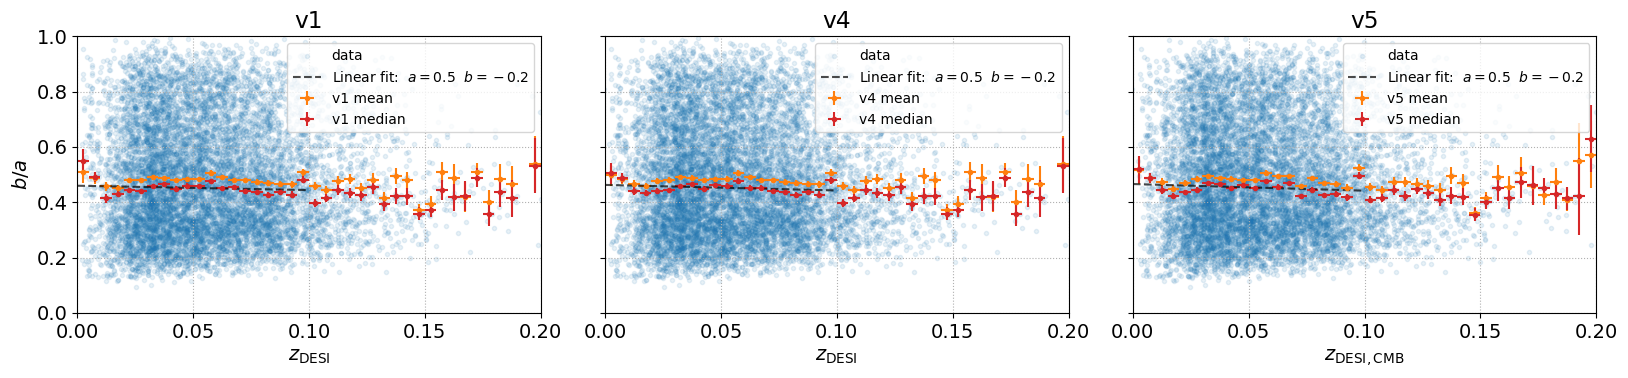

In [31]:
xbins = np.linspace(0, 0.2, 41)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'Z_DESI'
yval = 'BA'
yval_err = 'BA'

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')
a
#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:red')

#- Perform a fit to the median
select = (xc >= 0) & (xc <= 0.1)
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
_x = np.arange(0, 0.15, 0.05)
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:  $a={a:.1f}$  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v1',
       xlim=[0, 0.2],
       ylim=[0, 1],
       xlabel=r'$z_\mathrm{DESI}$',
       ylabel=r'$b/a$')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4[xval], tab4[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:red')

#- Perform a fit to the median
select = (xc >= 0) & (xc <= 0.1)
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
_x = np.arange(0, 0.15, 0.05)
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:  $a={a:.1f}$  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v4',
       xlabel=r'$z_\mathrm{DESI}$')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5[xval], tab5[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 median', color='tab:red')

#- Perform a fit to the median
select = (xc >= 0) & (xc <= 0.1)
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
_x = np.arange(0, 0.15, 0.05)
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:  $a={a:.1f}$  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v5',
       xlabel=r'$z_\mathrm{DESI, CMB}$')
ax.grid(ls=':');

### Peculiar velocity vs axis ratio and galaxy size

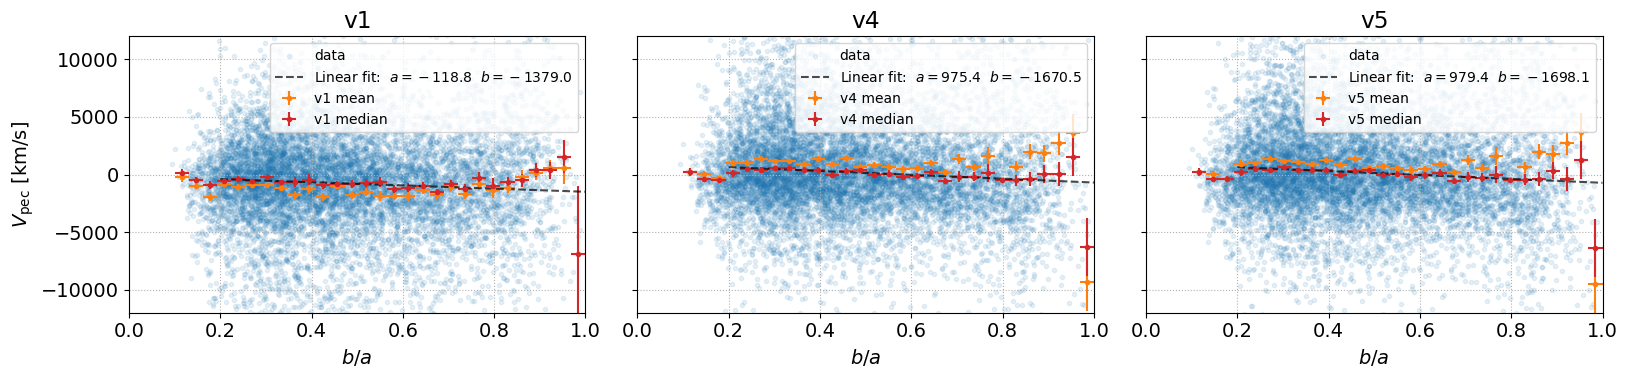

In [42]:
xbins = np.linspace(0.1, 1, 30)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'BA'
yval = 'V_PEC'
yval_err = 'VERR_PEC'

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)


ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:red')

#- Perform a fit to the median
select = (xc >= 0.2) & (xc <= 0.95)
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
_x = np.arange(0.2, 1.05, 0.05)
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:  $a={a:.1f}$  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v1',
       xlim=[0, 1],
       ylim=[-12000, 12000],
       xlabel=r'$b/a$',
       ylabel=r'$V_\text{pec}$ [km/s]')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4[xval], tab4[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:red')

#- Perform a fit to the median
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:  $a={a:.1f}$  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v4',
       xlabel=r'$b/a$')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5[xval], tab5[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 median', color='tab:red')

#- Perform a fit to the median
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:  $a={a:.1f}$  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v5',
       xlabel=r'$b/a$')
ax.grid(ls=':');

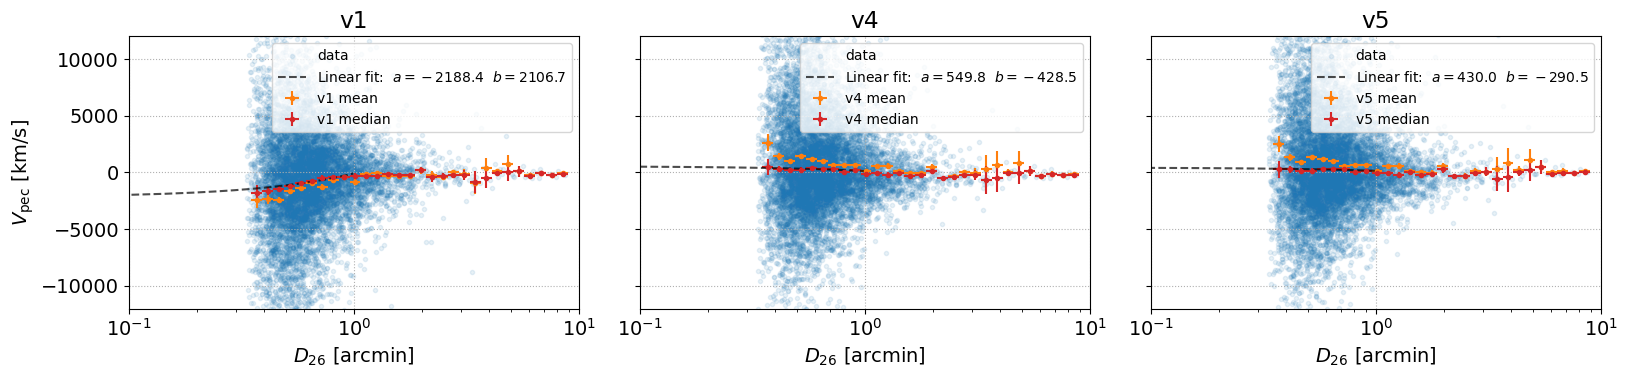

In [43]:
xbins = np.logspace(np.log10(0.35), 1, 31)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'D26'
yval = 'V_PEC'
yval_err = 'VERR_PEC'

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)


ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:red')

#- Perform a fit to the median
select = xc <= 1
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
_x = np.arange(np.log10(0.35), 1, 0.05)
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:  $a={a:.1f}$  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v1',
       xlim=[0.1, 10],
       xscale='log',
       ylim=[-12000, 12000],
       xlabel=r'$D_{26}$ [arcmin]',
       ylabel=r'$V_\text{pec}$ [km/s]')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4[xval], tab4[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:red')

#- Perform a fit to the median
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:  $a={a:.1f}$  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v4',
       xlabel=r'$D_{26}$ [arcmin]')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5[xval], tab5[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 median', color='tab:red')

#- Perform a fit to the median
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:  $a={a:.1f}$  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v5',
       xlabel=r'$D_{26}$ [arcmin]')
ax.grid(ls=':');

### Rotational velocity vs galaxy size

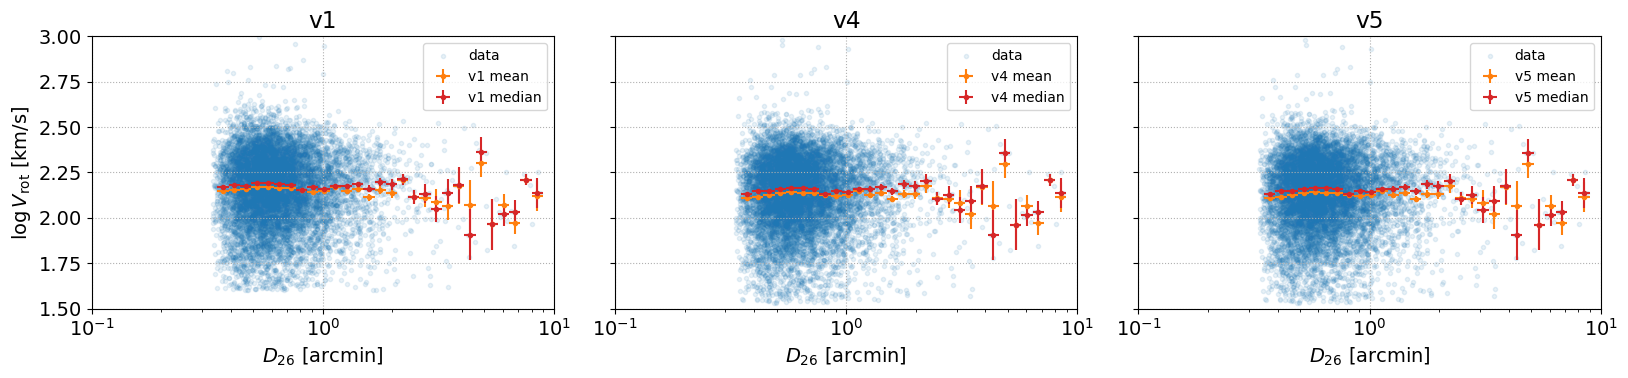

In [44]:
xbins = np.logspace(np.log10(0.35), 1, 31)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'D26'
yval = 'logV_0p4R26'
yval_err = 'logV_0p4R26_err'

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)


ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v1',
       xlim=[0.1, 10],
       xscale='log',
       ylim=[1.5, 3],
       xlabel=r'$D_{26}$ [arcmin]',
       ylabel=r'$\log{V_\text{rot}}$ [km/s]')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4[xval], tab4[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v4',
       xlabel=r'$D_{26}$ [arcmin]')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5[xval], tab5[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v5',
       xlabel=r'$D_{26}$ [arcmin]')
ax.grid(ls=':');

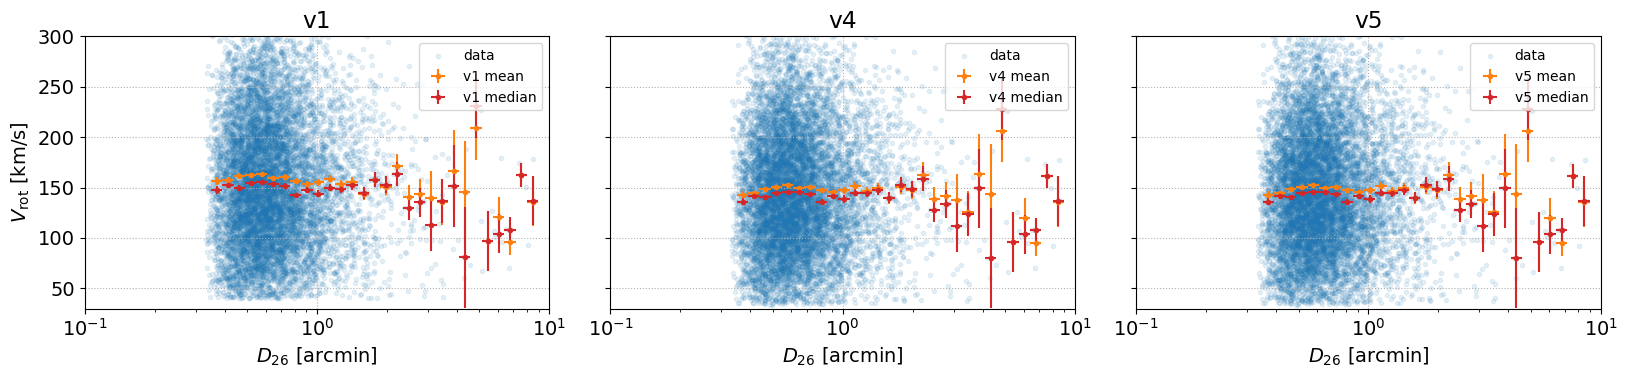

In [45]:
xbins = np.logspace(np.log10(0.35), 1, 31)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'D26'
yval = 'V_0p4R26'
yval_err = 'V_0p4R26_err'

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v1',
       xlim=[0.1, 10],
       xscale='log',
       ylim=[30, 300],
       xlabel=r'$D_{26}$ [arcmin]',
       ylabel=r'$V_\text{rot}$ [km/s]')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4[xval], tab4[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v4',
       xlabel=r'$D_{26}$ [arcmin]')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5[xval], tab5[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v5',
       xlabel=r'$D_{26}$ [arcmin]')
ax.grid(ls=':');

### Galaxy size vs redshift

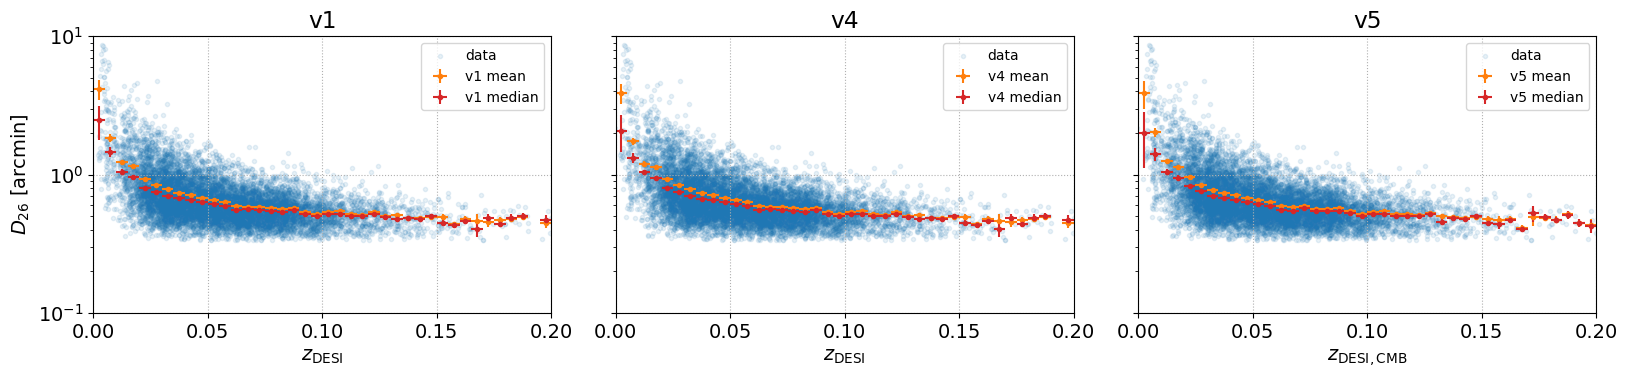

In [45]:
xbins = np.linspace(0, 0.2, 41)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'Z_DESI'
yval = 'D26'

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v1',
       ylim=[0.1, 10],
       yscale='log',
       xlim=[0, 0.2],
       ylabel=r'$D_{26}$ [arcmin]',
       xlabel=r'$z_{\rm DESI}$')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4[xval], tab4[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v4',
       xlabel=r'$z_{\rm DESI}$')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5[xval], tab5[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='v5',
       xlabel=r'$z_{\rm DESI, CMB}$')
ax.grid(ls=':');

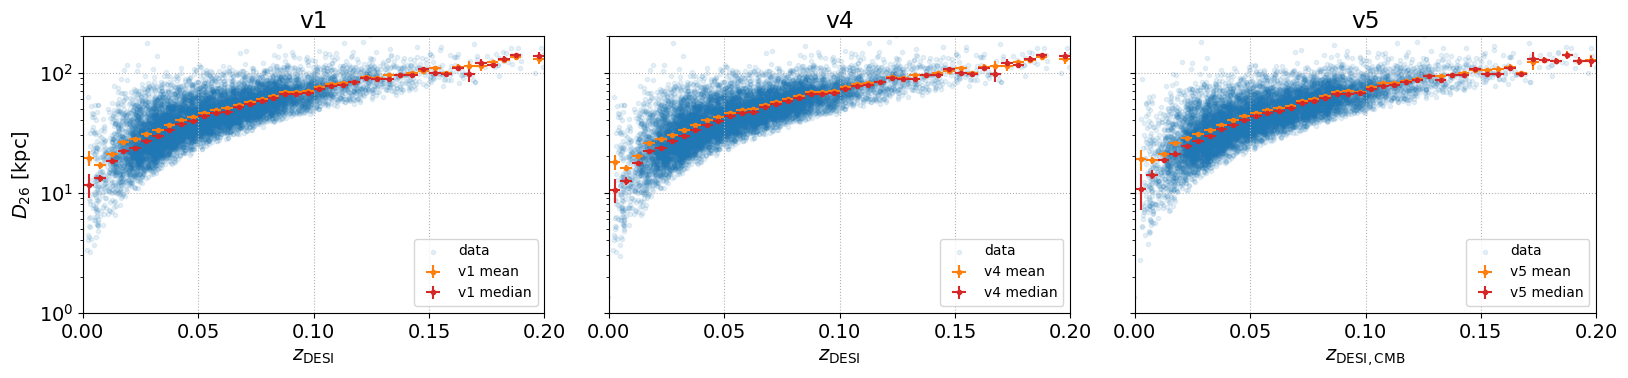

In [52]:
xbins = np.linspace(0, 0.2, 41)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'Z_DESI'
yval = 'D26_kpc'

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:red')

ax.legend(loc='lower right', fontsize=10)
ax.set(title='v1',
       ylim=[1, 200],
       yscale='log',
       xlim=[0, 0.2],
       ylabel=r'$D_{26}$ [kpc]',
       xlabel=r'$z_{\rm DESI}$')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4[xval], tab4[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:red')

ax.legend(loc='lower right', fontsize=10)
ax.set(title='v4',
       xlabel=r'$z_{\rm DESI}$')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5[xval], tab5[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 median', color='tab:red')

ax.legend(loc='lower right', fontsize=10)
ax.set(title='v5',
       xlabel=r'$z_{\rm DESI, CMB}$')
ax.grid(ls=':');

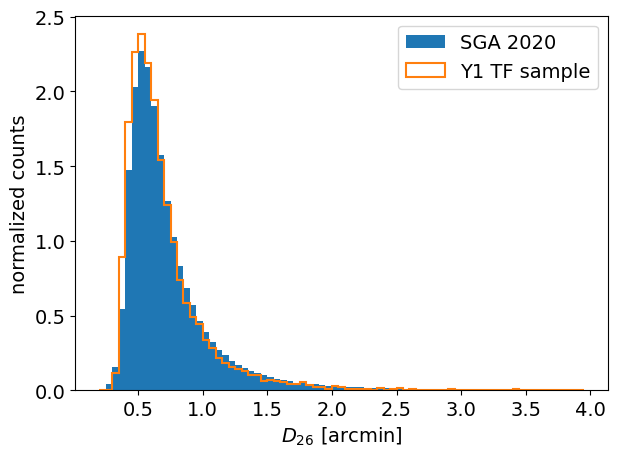

In [19]:
plt.figure(tight_layout=True)

D26_bins = np.arange(0.2, 4, 0.05)

plt.hist(SGA['D26'], bins=D26_bins, density=True, label='SGA 2020')
plt.hist(tab5['D26'], bins=D26_bins, density=True, histtype='step', linewidth=1.5, label='Y1 TF sample')

plt.xlabel('$D_{26}$ [arcmin]')
plt.ylabel('normalized counts')

plt.legend();

### Rotational velocity vs redshift

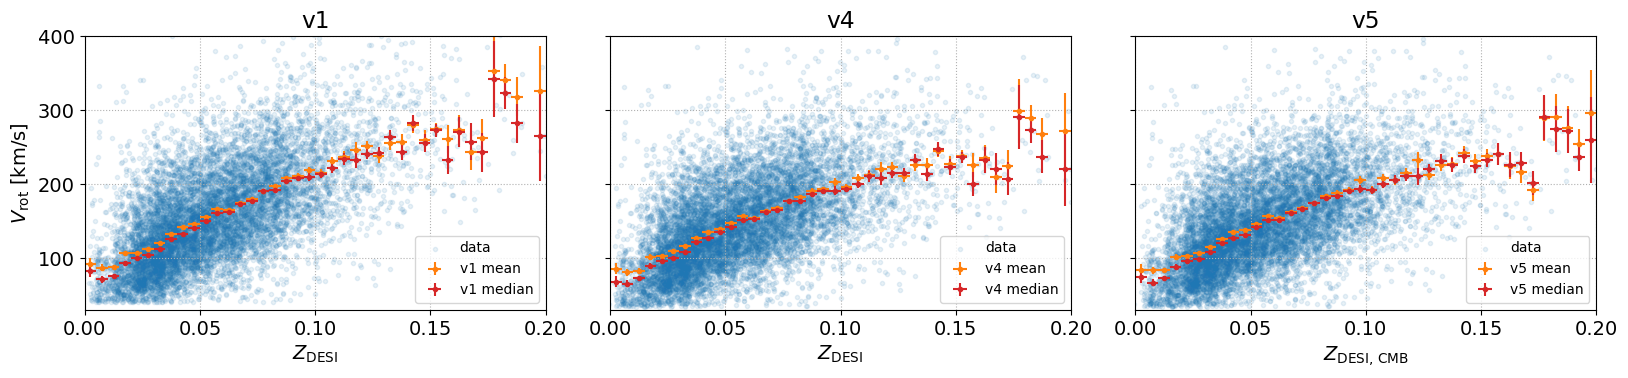

In [46]:
xbins = np.linspace(0, 0.2, 41)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'Z_DESI'
yval = 'V_0p4R26'
yval_err = 'V_0p4R26_err'

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)


ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:red')

ax.legend(loc='lower right', fontsize=10)
ax.set(title='v1',
       xlim=[0, 0.2],
       ylim=[30, 400],
       xlabel=r'$Z_\text{DESI}$',
       ylabel=r'$V_\text{rot}$ [km/s]')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4[xval], tab4[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:red')

ax.legend(loc='lower right', fontsize=10)
ax.set(title='v4',
       xlabel=r'$Z_\text{DESI}$')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5[xval], tab5[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 median', color='tab:red')

ax.legend(loc='lower right', fontsize=10)
ax.set(title='v5',
       xlabel=r'$Z_\text{DESI, CMB}$')
ax.grid(ls=':');

Since $V_\text{rot}$ is correlated with absolute magnitude, and our sample is pseudo-magnitude-limited, then we would expect to only observe more massive (i.e., faster rotating) objects at higher redshifts.

### Magnitude vs Redshift

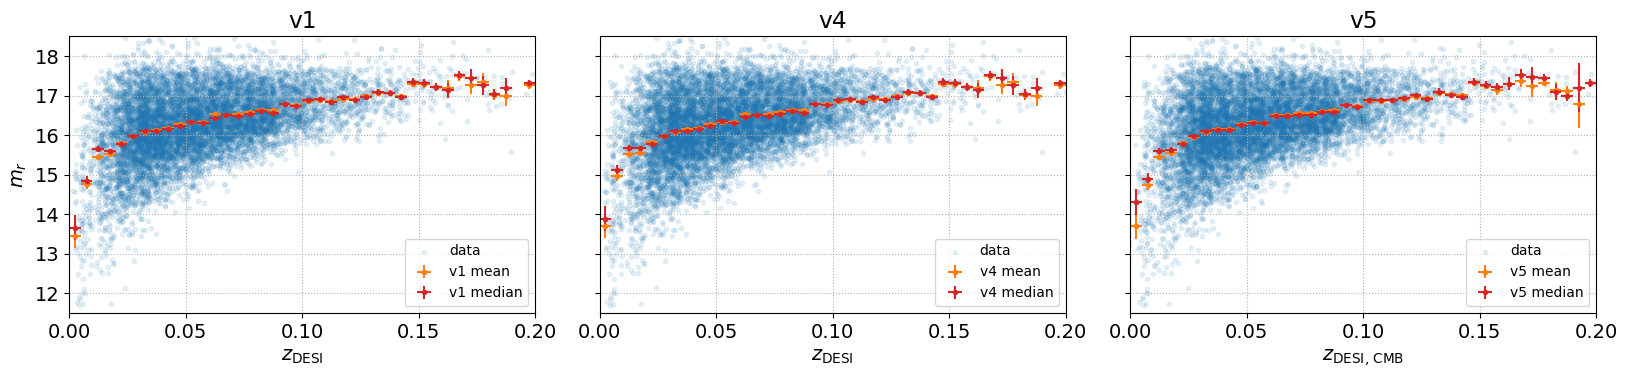

In [29]:
xbins = np.linspace(0, 0.2, 41)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'Z_DESI'
yval = 'R_MAG_SB26'
yval_err = 'R_MAG_SB26_ERR'

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:red')

ax.legend(loc='lower right', fontsize=10)
ax.set(title='v1',
       xlim=[0, 0.2],
       ylim=[11.5, 18.5],
       xlabel=r'$z_\text{DESI}$',
       ylabel=r'$m_r$')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4[xval], tab4[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:red')

ax.legend(loc='lower right', fontsize=10)
ax.set(title='v4',
       xlabel=r'$z_\text{DESI}$')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5[xval], tab5[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 median', color='tab:red')

ax.legend(loc='lower right', fontsize=10)
ax.set(title='v5',
       xlabel=r'$z_\text{DESI, CMB}$')
ax.grid(ls=':');

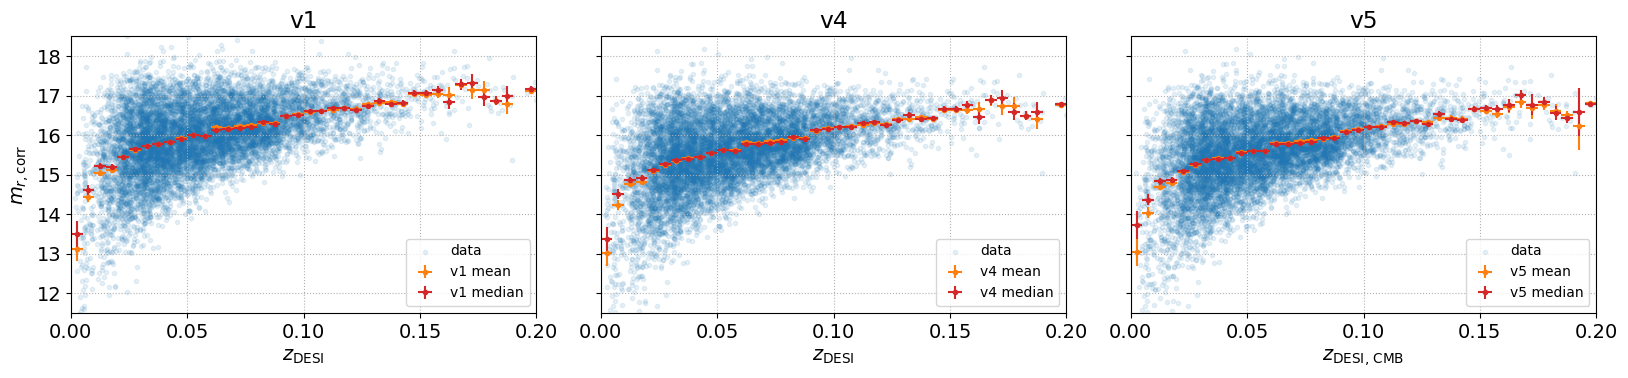

In [31]:
xbins = np.linspace(0, 0.2, 41)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'Z_DESI'
yval = 'R_MAG_SB26_CORR'
yval_err = 'R_MAG_SB26_CORR_ERR'

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:red')

ax.legend(loc='lower right', fontsize=10)
ax.set(title='v1',
       xlim=[0, 0.2],
       ylim=[11.5, 18.5],
       xlabel=r'$z_\text{DESI}$',
       ylabel=r'$m_{r,\text{corr}}$')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4[xval], tab4[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:red')

ax.legend(loc='lower right', fontsize=10)
ax.set(title='v4',
       xlabel=r'$z_\text{DESI}$')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5[xval], tab5[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 median', color='tab:red')

ax.legend(loc='lower right', fontsize=10)
ax.set(title='v5',
       xlabel=r'$z_\text{DESI, CMB}$')
ax.grid(ls=':');

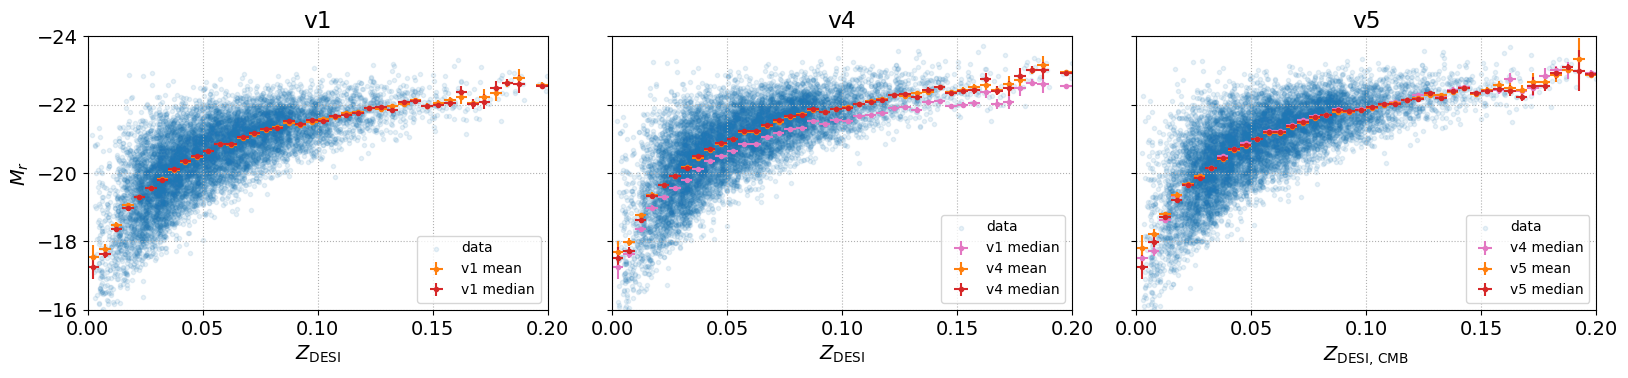

In [51]:
xbins = np.linspace(0, 0.2, 41)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'Z_DESI'
yval = 'R_ABSMAG_SB26'
yval_err = 'R_ABSMAG_SB26_ERR'

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)


ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='v1',
       xlim=[0, 0.2],
       ylim=[-16, -24],
       xlabel=r'$Z_\text{DESI}$',
       ylabel=r'$M_r$')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4[xval], tab4[yval], marker='.', alpha=0.1, label='data')

#- Plot v1
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:pink')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, tab4[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='v4',
       xlabel=r'$Z_\text{DESI}$')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5[xval], tab5[yval], marker='.', alpha=0.1, label='data')

#- Plot v4
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:pink')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, tab5[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='v5',
       xlabel=r'$Z_\text{DESI, CMB}$')
ax.grid(ls=':');

### Color vs Peculiar Velocity and Axis Ratio

Plot $g-r$ and $r-z$ vs derived PV and galaxy properties.

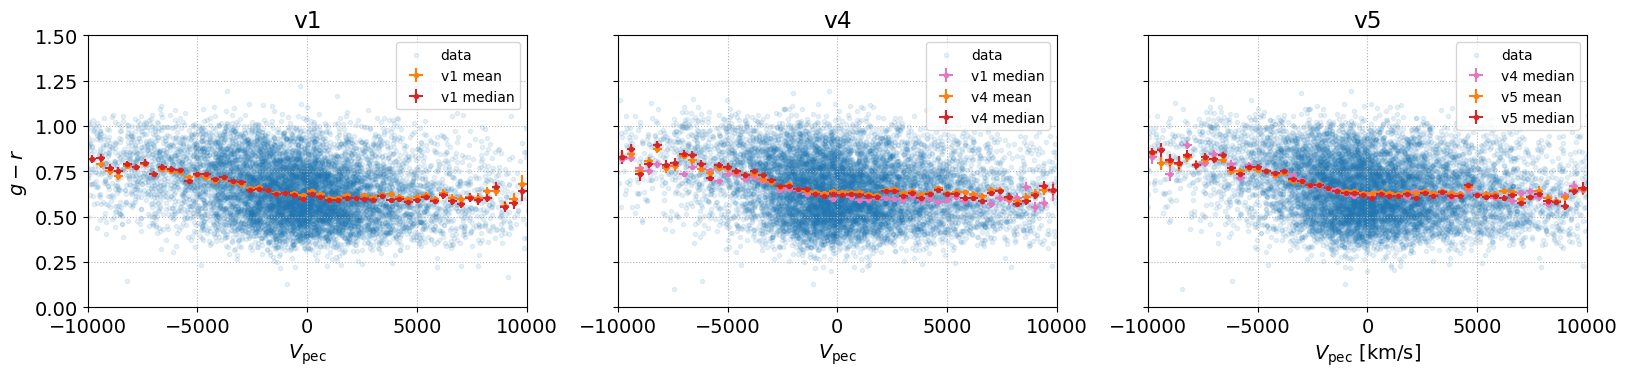

In [35]:
xbins = np.linspace(-10000, 10000, 51)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'V_PEC'
yval = 'g-r'

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)
# fig, ax = plt.subplots(1,1, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='v1',
       xlim=[-1e4, 1e4],
       ylim=[0, 1.5],
       xlabel=r'$V_\text{pec}$',
       ylabel=r'$g-r$')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4[xval], tab4[yval], marker='.', alpha=0.1, label='data')

#- Plot v1
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:pink')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='v4',
       xlabel=r'$V_\text{pec}$')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5[xval], tab5[yval], marker='.', alpha=0.1, label='data')

#- Plot v4
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:pink')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='v5',
       xlabel=r'$V_\text{pec}$ [km/s]', 
       # xlim=[-1e4, 1e4], 
       # ylim=[0, 1], 
       # ylabel=r'$g - r$',
      )
ax.grid(ls=':');

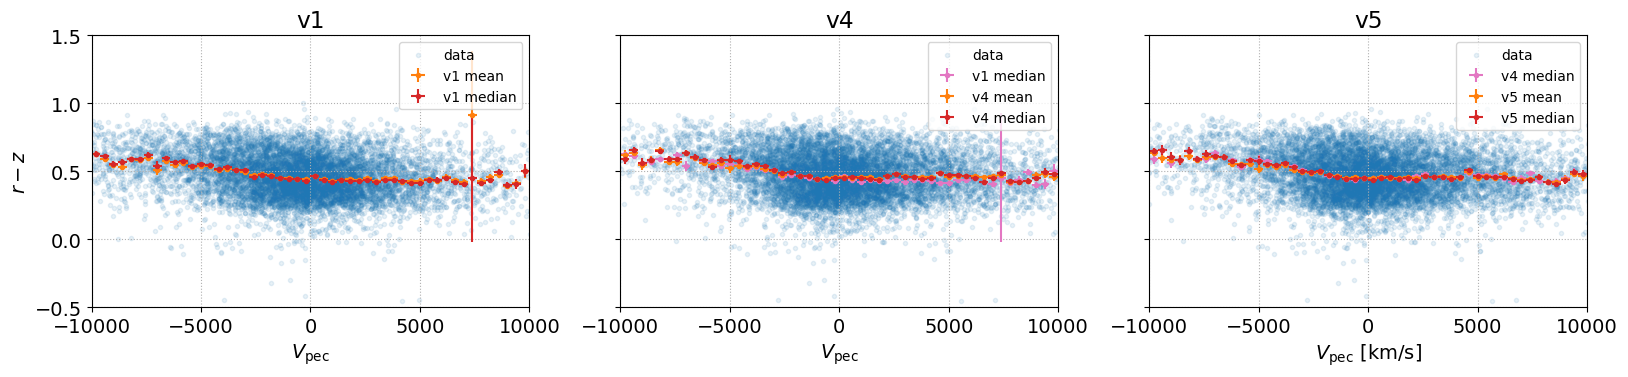

In [39]:
xbins = np.linspace(-10000, 10000, 51)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'V_PEC'
yval = 'r-z'

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)
# fig, ax = plt.subplots(1,1, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='v1',
       xlim=[-1e4, 1e4],
       ylim=[-0.5, 1.5],
       xlabel=r'$V_\text{pec}$',
       ylabel=r'$r-z$')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4[xval], tab4[yval], marker='.', alpha=0.1, label='data')

#- Plot v1
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:pink')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='v4',
       xlabel=r'$V_\text{pec}$')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5[xval], tab5[yval], marker='.', alpha=0.1, label='data')

#- Plot v4
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:pink')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='v5', 
       xlabel=r'$V_{\rm pec}$ [km/s]', 
       # xlim=[-1e4, 1e4], 
       # ylim=[-0.2, 0.75], 
       # ylabel='$r - z$',
      )
ax.grid(ls=':');

/tmp/ipykernel_1917755/3005628098.py:42: RuntimeWarning: divide by zero encountered in true_divide
  e = np.sqrt((mean2 - mean**2) / (N - 1))
/tmp/ipykernel_1917755/3005628098.py:42: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt((mean2 - mean**2) / (N - 1))


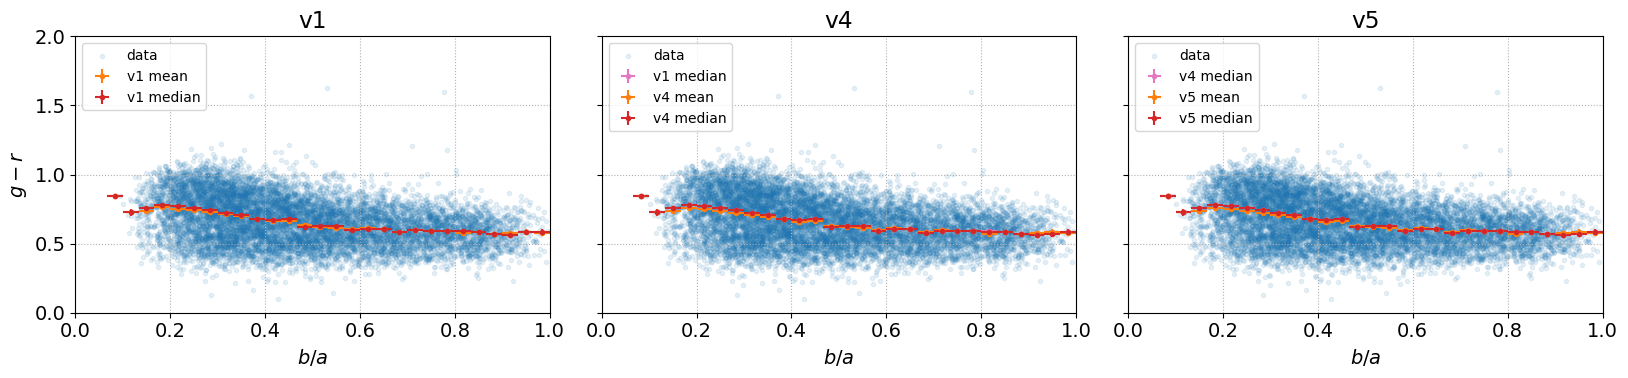

In [40]:
xbins = np.linspace(0, 1, 31)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'BA'
yval = 'g-r'

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)
# fig, ax = plt.subplots(1,1, tight_layout=True)


ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='v1',
       xlim=[0, 1],
       ylim=[0, 2],
       xlabel=r'$b/a$',
       ylabel=r'$g-r$')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4[xval], tab4[yval], marker='.', alpha=0.1, label='data')

#- Plot v1
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:pink')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='v4',
       xlabel=r'$b/a$')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5[xval], tab5[yval], marker='.', alpha=0.1, label='data')

#- Plot v4
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:pink')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='v5',
       xlabel=r'$b/a$', 
       # xlim=[0, 1],
       # ylim=[0, 1],
       # ylabel=r'$g-r$',
      )
ax.grid(ls=':');

/tmp/ipykernel_1917755/3005628098.py:42: RuntimeWarning: divide by zero encountered in true_divide
  e = np.sqrt((mean2 - mean**2) / (N - 1))


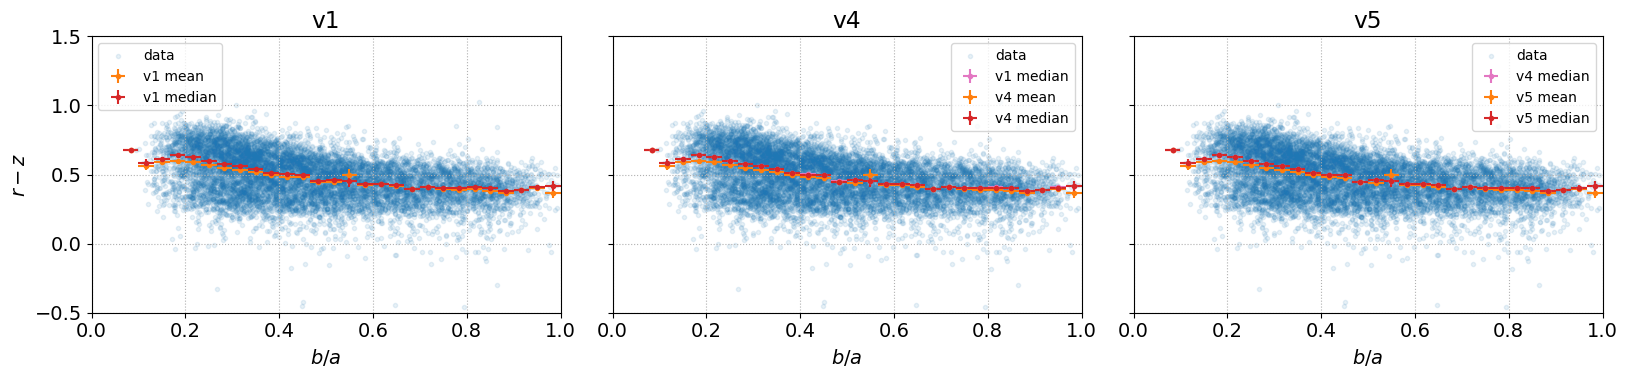

In [42]:
xbins = np.linspace(0, 1, 31)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'BA'
yval = 'r-z'

fig, axes = plt.subplots(1,3, figsize=(16.5,4), sharex=True, sharey=True, tight_layout=True)
# fig, ax = plt.subplots(1,1, tight_layout=True)


ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='v1',
       xlim=[0, 1],
       ylim=[-0.5, 1.5],
       xlabel=r'$b/a$',
       ylabel=r'$r-z$')
ax.grid(ls=':')


ax = axes[1]
ax.scatter(tab4[xval], tab4[yval], marker='.', alpha=0.1, label='data')

#- Plot v1
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v1 median', color='tab:pink')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab4[xval], tab4[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='v4',
       xlabel=r'$b/a$')
ax.grid(ls=':')


ax = axes[2]
ax.scatter(tab5[xval], tab5[yval], marker='.', alpha=0.1, label='data')

#- Plot v4
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v4 median', color='tab:pink')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab5[xval], tab5[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='v5 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='v5',
       xlabel=r'$b/a$', 
       # xlim=[0, 1],
       # ylim=[-0.2, 0.75],
       # ylabel=r'$r-z$',
      )
ax.grid(ls=':');

## TF Distance Modulus vs Redshift

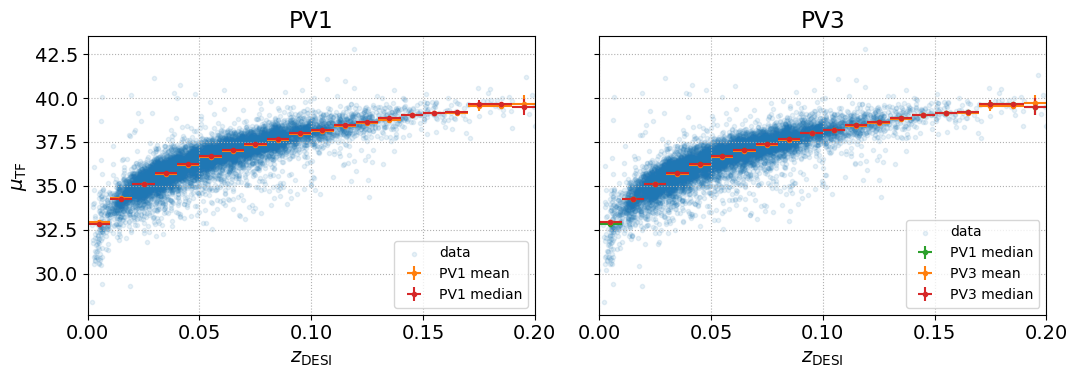

In [25]:
xbins = np.linspace(0, 0.2, 21)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'Z_DESI'
yval = 'MU_TF'

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='PV1',
       xlim=[0, 0.2],
       # ylim=[-0.5, 1.5],
       xlabel=r'$z_\mathrm{DESI}$',
       ylabel=r'$\mu_\mathrm{TF}$')
ax.grid(ls=':')

ax = axes[1]
ax.scatter(tab3[xval], tab3[yval], marker='.', alpha=0.1, label='data')

#- Plot PV1
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:green')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='PV3',
       xlabel=r'$z_\mathrm{DESI}$')
ax.grid(ls=':')

In [26]:
# isbig = d26 > 2

# fig, ax = plt.subplots(1,1, figsize=(3,9), tight_layout=True)

# ax.scatter(logvrot[~isbig], Mr26[~isbig], marker='.', alpha=0.2)
# ax.scatter(logvrot[isbig], Mr26[isbig], marker='.', alpha=0.5)

# ax.set(xlim=(0.5, 3),
#        ylim=(-12,-28));